In [31]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
#plt.rcParams['pdf.fonttype'] = 42
import pandas as pd
from IPython.core.display import HTML
import numpy as np
%matplotlib inline
import glob
import readData
reload(readData) #avoid kernel restart if changed
import re
#import databaseQuery

In [32]:
## Read in the data as a pandas dataframe
# Files should be .csv format in \Data\ subdirectory
# Files should be simply named SAGE_SOUTH or RIV_NORTH, without numerals
allFiles = glob.glob("Data\*.csv") #get all files with csv extension in this subfolder
print allFiles


#Return pandas dataframe with all the data, datetime index
#toggle saveCSV True/False to save a csv of the compiled data

voltage, radius = readData.readCSV(allFiles, saveCSV = False) 


['Data\\RIV_NORTH.csv', 'Data\\RIV_SOUTH.csv', 'Data\\SAGE_NORTH.csv', 'Data\\SAGE_SOUTH.csv']


In [33]:
radius.head()

,60020,60021,60022,60023,60024,60025,60026,60027,60002,60000,...,60010,60007,60018,60019,60017,60016,60015,60014,60012,60013
2015-06-25 12:30:00,13958.80000,2.66044,2.66044,13589.60000,2.66044,4288.80000,2.66044,2.66044,NaN,NaN,...,NaN,NaN,3.97892,3.97892,3.97892,3.97892,3.97892,2.65264,-2960.56,-3659.52
2015-06-25 13:00:00,13958.00000,2.66048,2.66048,13585.60000,2.66048,4279.60000,2.66048,2.66048,2.63844,2.63844,...,3.94492,3.50660,3.97892,3.97892,3.97892,3.97892,3.97892,2.87368,-3608.44,-5562.80
2015-06-25 13:30:00,2.65824,2.66044,2.66044,2.65824,2.66044,2.66020,2.66044,2.66044,2.63844,2.63844,...,3.94496,3.50664,3.97884,3.97884,3.97884,3.97884,3.97884,2.87360,-3876.96,-5849.60
2015-06-25 14:00:00,2.65820,2.66040,2.66040,2.65820,2.66040,2.66016,2.66040,2.66040,2.63844,2.63844,...,3.28744,3.72576,3.75784,3.97888,3.97888,3.97888,3.97888,3.09468,-4281.60,-6322.00
2015-06-25 14:00:00,2.65820,2.66040,2.66040,2.65820,2.66040,2.66016,2.66040,2.66040,2.63844,2.63844,...,10800.00000,9130.00000,3.75784,3.97888,3.97888,3.97888,3.97888,3.09468,-4281.60,-6322.00


In [34]:
radius.to_csv('radius.csv')

In [46]:
## Read in the metadata as a pandas dataframe
metadata = pd.read_csv('PISTON_DENDROMETER_METADATA.csv',sep=',', dtype=str)

#Create dictionaries between sensor ID and metadata info
Site = dict(zip(metadata['Micron Displacement DSID'], metadata['Site'] )) 
Slope = dict(zip(metadata['Micron Displacement DSID'], metadata['Slope'] )) 
Species = dict(zip(metadata['Micron Displacement DSID'], metadata['Species'] )) 
Tree = dict(zip(metadata['Micron Displacement DSID'], metadata['Tree #'] )) 
Sensor = dict(zip(metadata['Micron Displacement DSID'], metadata['Sensor ID'] )) 


In [44]:
radius.tail()

,60020,60021,60022,60023,60024,60025,60026,60027,60002,60000,...,60010,60007,60018,60019,60017,60016,60015,60014,60012,60013
2024-07-13 02:00:00,17962.0,10144.8,9016.8,5865.6,2809.16,1925.40,19.9732,1271.60,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-13 02:30:00,17959.6,10186.8,9008.4,5864.4,2809.64,1927.20,19.9732,1271.64,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-13 03:00:00,17959.2,10299.2,9011.6,5866.8,2810.96,1928.96,19.9732,1271.64,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-13 03:30:00,17960.0,10431.6,9008.8,5866.4,2812.28,1930.72,19.9732,1271.64,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-13 04:00:00,17958.8,10394.0,9006.4,5866.8,2813.16,1930.72,19.9732,1271.60,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


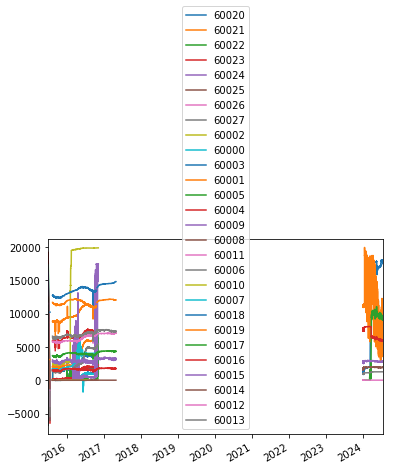

In [36]:
radius.plot()

In [61]:
#%% SPECIFY TIME RANGE OF SERIES
startDateTime = pd.to_datetime('2017-04-22 00:00:00')
stopDateTime = pd.to_datetime('2017-04-24 00:00:00')

# startDateTime = pd.to_datetime('2024-07-11 00:00:00')
# stopDateTime = pd.to_datetime('2024-07-13 00:00:00')

radiusTR = radius[(pd.to_datetime(radius.index) > startDateTime) & 
                (pd.to_datetime(radius.index) < stopDateTime)]


In [62]:
radiusTR.tail()

,60020,60021,60022,60023,60024,60025,60026,60027,60002,60000,...,60010,60007,60018,60019,60017,60016,60015,60014,60012,60013
2017-04-23 21:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14760.8,12017.6,4335.2,1730.28,3108.40,13.2896,7055.2,7316.0
2017-04-23 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14760.8,12018.0,4336.0,1730.32,3109.80,13.2896,7055.6,7317.2
2017-04-23 22:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14761.6,12017.2,4336.4,1730.40,3112.56,13.2904,7055.6,7318.8
2017-04-23 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14762.0,12017.2,4336.8,1730.44,3114.00,13.2904,7056.0,7319.2
2017-04-23 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,14761.2,12016.8,4336.8,1731.40,3115.48,13.2912,7056.4,7319.6


In [63]:
## Import from mySQL database 
#Convert datetime stamps to strings for the sql query
dateStart = str(startDateTime.year) + '-' + str(startDateTime.month) + '-' + str(startDateTime.day)
dateStop =  str(stopDateTime.year) + '-' + str(stopDateTime.month) + '-' + str(stopDateTime.day)

#here we make use of external .py file with odmquery function (thanks Collin!) to get data from the database
#1672 = cumulative WY precip, in mm
#1785 = Rainfall mm TB4 WSAM RWS_Rain_TB4_Tot2015-03-26 (ongoing)Rainfall mmAngelo Meadow WSwsam0 to 700TB4mm-L Rain Gage
#2958 = Barometric Pressure, WSSR, mBar
#2959 = Rainfall, WSSR, mm
#3048 = Rainfall Cumulative mm Sagehorn
# atmP = databaseQuery.odmquery(dateStart, dateStop, '2958', True)
# atmP.plot()
#rain = databaseQuery.odmquery(dateStart, dateStop, '2957', True)



In [64]:

#center to zero

radiusMin = radiusTR.apply(np.min)

radiusZeroed =  radiusTR-radiusMin



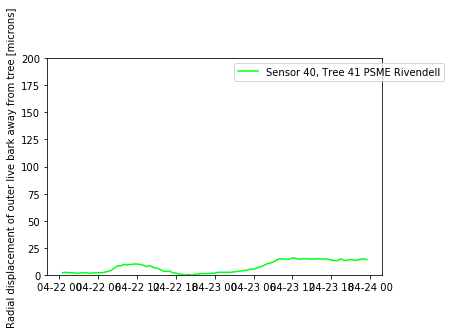

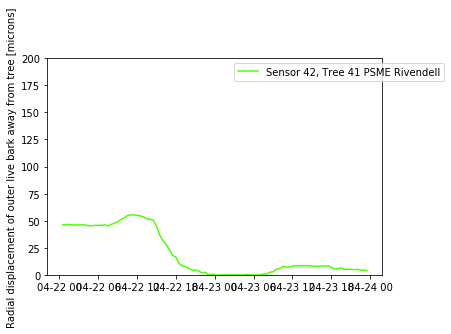

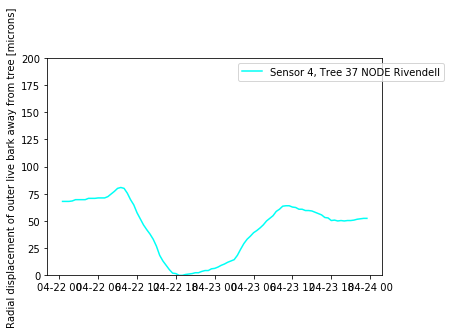

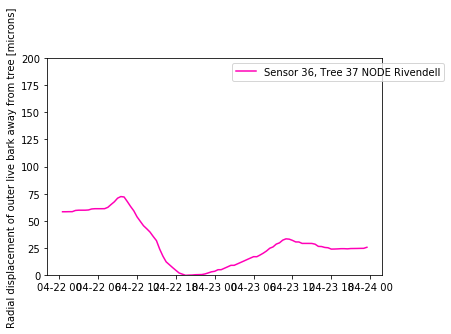

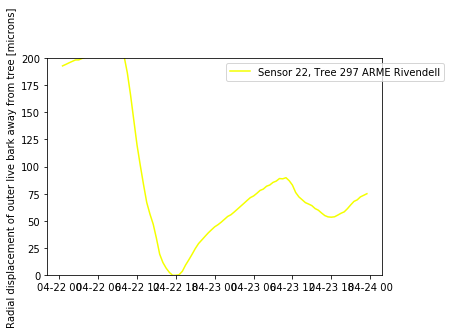

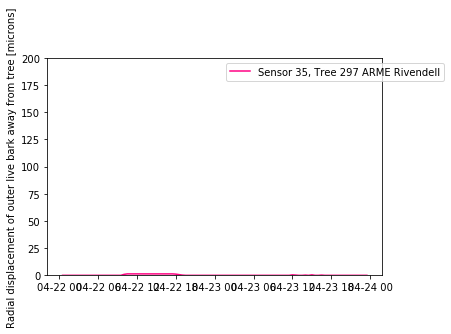

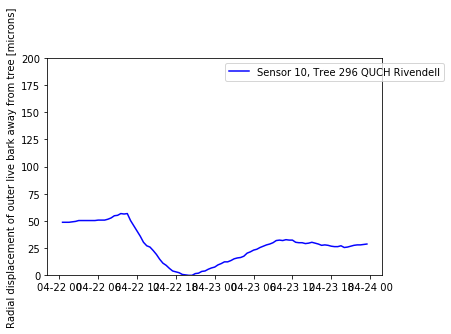

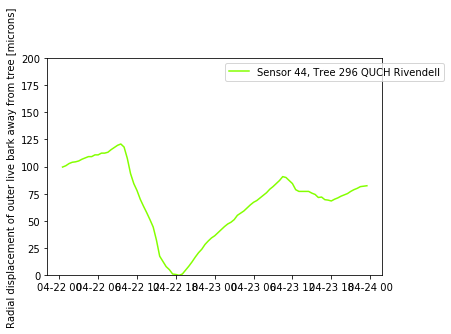

In [66]:
# fig, ax = plt.subplots(2, sharex=True, figsize=(17, 22))

fig = plt.figure()
# Get unique names of species
uniq = list(set(metadata['Sensor ID']))

# Set the color map to match the number of species
# z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('hsv') )


for column in radiusZeroed:
#         plt.figure()
    if Site[column] == 'Rivendell':
        if Slope[column]=='N':
            label=('Sensor ' + Sensor[column] + ', Tree '+Tree[column] + ' ' + Species[column] + ' ' + Site[column])
            ax = plt.plot(radiusZeroed.index, radiusZeroed[column], 
                     color=scalarMap.to_rgba(uniq.index(Sensor[column])), 
                     label = label)
            plt.legend(bbox_to_anchor=(1.2, 1))
            plt.ylabel('Radial displacement of outer live bark away from tree [microns]')
            plt.ylim([0,200])
            plt.savefig('Figs/FinalDiagnostic/'+label+'.pdf', format='pdf', bbox_inches='tight')
            plt.show()

In [43]:
Slope

{'60000': 'S',
 '60001': 'S',
 '60002': 'S',
 '60003': 'S',
 '60004': 'S',
 '60005': 'S',
 '60006': 'N',
 '60007': 'N',
 '60008': 'N',
 '60009': 'N',
 '60010': 'N',
 '60011': 'N',
 '60012': 'N',
 '60013': 'N',
 '60014': 'N',
 '60015': 'N',
 '60016': 'N',
 '60017': 'N',
 '60018': 'N',
 '60019': 'N',
 '60020': 'S',
 '60021': 'S',
 '60022': 'S',
 '60023': 'S',
 '60024': 'S',
 '60025': 'S',
 '60026': 'S',
 '60027': 'S'}